In [81]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import plotly
import plotly.graph_objects as go
import plotly.tools as tls
import plotly.express as px
import requests

from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
init_notebook_mode(connected=True)

%matplotlib inline

In [82]:
from IPython.display import SVG
def display_svg(svg_code):
    return SVG(svg_code)

# Report of French Employment, Salaries, Population per Town 

### Table of Contents
* [1. Basic info](#chapter1)
* [2 Data loading and cleaning](#chapter2)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](#section_1_2)
* [3. Data analysis](#chapter3)
    * [3.1. Current French labour market information](#section_3_1)
        * [3.1.1. The unemployment rate](#section_3_1_1)
        * [3.1.2. Mean salary for France](#section_3_1_2)
        * [3.1.3. Mean salary by working position](#section_3_1_3) 
        * [3.1.4. Mean salary by age](#section_3_1_4)
    * [3.2. Labour situation by regions](#section_3_2)
        * [3.2.1. Mean salary per region](#section_3_2_1)
        * [3.2.2. Regions with the lowest and highest salaries](#section_3_2_2) 
        * [3.2.3. Salary per region and gender](#section_3_2_3) 
    * [3.3. Labour situation by cities](#section_3_3)
        * [3.3.1. Mean salary per town](#section_3_3_1)
        * [3.3.2. Mean salary per town and gender](#section_3_3_2) 
        * [3.3.3. Mean salary per town and age](#section_3_3_3)

# 1. Basic info <a class="anchor" id="chapter1"></a>

Dataset is coming from **INSEE**. INSEE is the official french institute gathering data of many types around France. 
It can be demographic (Births, Deaths, Population Density…), Economic (Salary, Firms by activity / size…) and more. Data and descriptin can be found at <a href=" https://www.kaggle.com/etiennelq/french-employment-by-town?select=net_salary_per_town_categories.csv">this link</a>. Four files are in the dataset:

**baseetablissementpartrancheeffectif** : give information on the number of firms in every french town, categorized by size , come from INSEE. 
- CODGEO : geographique code for the town (can be joined with codeinsee column from "namegeographic_information.csv')
- LIBGEO : name of the town (in french) 
- REG : region number 
- DEP : depatment number 
- E14TST : total number of firms in the town 
- E14TS0ND : number of unknown or null size firms in the town 
- E14TS1 : number of firms with 1 to 5 employees in the town 
- E14TS6 : number of firms with 6 to 9 employees in the town 
- E14TS10 : number of firms with 10 to 19 employees in the town
- E14TS20 : number of firms with 20 to 49 employees in the town
- E14TS50 : number of firms with 50 to 99 employees in the town
- E14TS100 : number of firms with 100 to 199 employees in the town
- E14TS200 : number of firms with 200 to 499 employees in the town
- E14TS500 : number of firms with more than 500 employees in the town

**namegeographicinformation** : give geographic data on french town (mainly latitude and longitude, but also region / department codes and names )
- EU_circo : name of the European Union Circonscription
- code_région : code of the region attached to the town
- nom_région : name of the region attached to the town
- chef.lieu_région : name the administrative center around the town
- numéro_département : code of the department attached to the town
- nom_département : name of the department attached to the town
- préfecture : name of the local administrative division around the town
- numéro_circonscription : number of the circumpscription
- nom_commune : name of the town
- codes_postaux : post-codes relative to the town
- code_insee : unique code for the town
- latitude : GPS latitude
- longitude : GPS longitude
- éloignement

**netsalarypertownper_category** : salaries around french town per job categories, age and sex
- CODGEO : unique code of the town
- LIBGEO : name of the town
- SNHM14 : mean net salary
- SNHMC14 : mean net salary per hour for executive
- SNHMP14 : mean net salary per hour for middle manager
- SNHME14 : mean net salary per hour for employee
- SNHMO14 : mean net salary per hour for worker
- SNHMF14 : mean net salary for women
- SNHMFC14 : mean net salary per hour for feminin executive
- SNHMFP14 : mean net salary per hour for feminin middle manager
- SNHMFE14 : mean net salary per hour for feminin employee
- SNHMFO14 : mean net salary per hour for feminin worker
- SNHMH14 : mean net salary for man
- SNHMHC14 : mean net salary per hour for masculin executive
- SNHMHP14 : mean net salary per hour for masculin middle manager
- SNHMHE14 : mean net salary per hour for masculin employee
- SNHMHO14 : mean net salary per hour for masculin worker
- SNHM1814 : mean net salary per hour for 18-25 years old
- SNHM2614 : mean net salary per hour for 26-50 years old
- SNHM5014 : mean net salary per hour for >50 years old
- SNHMF1814 : mean net salary per hour for women between 18-25 years old
- SNHMF2614 : mean net salary per hour for women between 26-50 years old
- SNHMF5014 : mean net salary per hour for women >50 years old
- SNHMH1814 : mean net salary per hour for men between 18-25 years old
- SNHMH2614 : mean net salary per hour for men between 26-50 years old
- SNHMH5014 : mean net salary per hour for men >50 years old

**population** : demographic information in France per town, age, sex and living mode
- <NIVGEO : geographic level (arrondissement, communes…)
- CODGEO : unique code for the town
- LIBGEO : name of the town (might contain some utf-8 errors, this information has better quality namegeographicinformation)
- MOCO : cohabitation mode : [list and meaning available in Data description]
- AGE80_17 : age category (slice of 5 years) | ex : 0 -> people between 0 and 4 years old
- SEXE : sex, 1 for men | 2 for women
- NB : number of people in the category

**departments.geojson** : contains the borders of french departments. From Gregoire David (github)


This report is using only **netsalarypertownper_category** and **name_geographic_information** parts. Other files are described for further analysis purposes if needed. These datasets can be merged by : CODGEO = code_insee.



# 2. Data loading and cleaning <a class="anchor" id="chapter2"></a>

In [83]:
data_1 = pd.read_csv("net_salary_per_town_categories.csv")

In [84]:
headers_1  = {"CODGEO" : "unique code of the town",
"LIBGEO" : "name of the town",
"SNHM14" : "mean net salary",
"SNHMC14" : "mean net salary per hour for executive",
"SNHMP14" : "mean net salary per hour for middle manager",
"SNHME14" : "mean net salary per hour for employee",
"SNHMO14" : "mean net salary per hour for worker",
"SNHMF14" : "mean net salary for women",
"SNHMFC14" : "mean net salary per hour for feminin executive",
"SNHMFP14" : "mean net salary per hour for feminin middle manager",
"SNHMFE14" : "mean net salary per hour for feminin employee",
"SNHMFO14" : "mean net salary per hour for feminin worker",
"SNHMH14" : "mean net salary for man",
"SNHMHC14" : "mean net salary per hour for masculin executive",
"SNHMHP14" : "mean net salary per hour for masculin middle manager",
"SNHMHE14" : "mean net salary per hour for masculin employee",
"SNHMHO14" : "mean net salary per hour for masculin worker",
"SNHM1814" : "mean net salary per hour for 18-25 years old",
"SNHM2614" : "mean net salary per hour for 26-50 years old",
"SNHM5014" : "mean net salary per hour for >50 years old",
"SNHMF1814" : "mean net salary per hour for women between 18-25 years old",
"SNHMF2614" : "mean net salary per hour for women between 26-50 years old",
"SNHMF5014" : "mean net salary per hour for women >50 years old",
"SNHMH1814" : "mean net salary per hour for men between 18-25 years old",
"SNHMH2614" : "mean net salary per hour for men between 26-50 years old",
"SNHMH5014" : "mean net salary per hour for men >50 years old"}

In [85]:
data_1.rename(columns=headers_1, inplace=True)

In [86]:
data_1.head(10)

unique code of the town          name of the town  mean net salary  \
0                   01004         Ambérieu-en-Bugey             13.7   
1                   01007                  Ambronay             13.5   
2                   01014                    Arbent             13.5   
3                   01024                  Attignat             12.9   
4                   01025             Bâgé-la-Ville             13.0   
5                   01027                     Balan             13.9   
6                   01031                 Bellignat             12.4   
7                   01032                 Béligneux             14.0   
8                   01033  Bellegarde-sur-Valserine             11.5   
9                   01034                    Belley             12.4   

   mean net salary per hour for executive  \
0                                    24.2   
1                                    22.1   
2                                    27.6   
3                                    21.8   
4                                    22.8   
5                                    22.2   
6                                    24.0   
7                                    23.1   
8                                    21.2   
9                                    23.4   

   mean net salary per hour for middle manager  \
0                                         15.5   
1                                         14.7   
2                                         15.6   
3                                         14.1   
4                                         14.1   
5                                         15.1   
6                                         13.1   
7                                         15.3   
8                                         13.5   
9                                         14.1   

   mean net salary per hour for employee  mean net salary per hour for worker  \
0                                   10.3                                 11.2   
1                                   10.7                                 11.4   
2                                   11.1                                 11.1   
3                                   11.0                                 11.3   
4                                   10.5                                 11.1   
5                                   11.0                                 11.4   
6                                   10.5                                 10.4   
7                                   10.9                                 11.3   
8                                    9.9                                 10.5   
9                                   10.3                                 10.5   

   mean net salary for women  mean net salary per hour for feminin executive  \
0                       11.6                                            19.1   
1                       11.9                                            19.0   
2                       10.9                                            19.5   
3                       11.4                                            19.0   
4                       11.6                                            19.4   
5                       12.5                                            20.3   
6                       10.9                                            20.7   
7                       12.4                                            20.5   
8                       10.3                                            20.8   
9                       11.0                                            21.5   

   mean net salary per hour for feminin middle manager  ...  \
0                                               13.2    ...   
1                                               13.3    ...   
2                                               11.7    ...   
3                                               13.0    ...   
4                                               13.6    ...   
5          

In [87]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5136 entries, 0 to 5135
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   unique code of the town                                     5136 non-null   object 
 1   name of the town                                            5136 non-null   object 
 2   mean net salary                                             5136 non-null   float64
 3   mean net salary per hour for executive                      5136 non-null   float64
 4   mean net salary per hour for middle manager                 5136 non-null   float64
 5   mean net salary per hour for employee                       5136 non-null   float64
 6   mean net salary per hour for worker                         5136 non-null   float64
 7   mean net salary for women                                   5136 non-null   float64
 8 

In [88]:
data_1.describe()

mean net salary  mean net salary per hour for executive  \
count      5136.000000                             5136.000000   
mean         13.706386                               23.703836   
std           2.559329                                2.836183   
min          10.200000                               16.000000   
25%          12.100000                               21.900000   
50%          13.000000                               23.200000   
75%          14.400000                               24.900000   
max          43.300000                               51.500000   

       mean net salary per hour for middle manager  \
count                                  5136.000000   
mean                                     14.575876   
std                                       1.490110   
min                                      11.600000   
25%                                      13.800000   
50%                                      14.400000   
75%                                      15.100000   
max                                      54.600000   

       mean net salary per hour for employee  \
count                            5136.000000   
mean                               10.564505   
std                                 0.811775   
min                                 8.700000   
25%                                10.000000   
50%                                10.400000   
75%                                10.900000   
max                                17.500000   

       mean net salary per hour for worker  mean net salary for women  \
count                          5136.000000                5136.000000   
mean                             11.235650                  12.038026   
std                               1.221755                   1.787995   
min                               8.300000                   9.300000   
25%                              10.600000                  10.900000   
50%                              11.000000                  11.500000   
75%                              11.600000                  12.700000   
max                              46.300000                  26.700000   

       mean net salary per hour for feminin executive  \
count                                     5136.000000   
mean                                        20.220502   
std                                          2.327550   
min                                         12.000000   
25%                                         18.800000   
50%                                         20.000000   
75%                                         21.400000   
max                                         35.500000   

       mean net salary per hour for feminin middle manager  \
count                                        5136.000000     
mean                                           13.274260     
std                                             0.990166     
min                                            10.600000     
25%                                            12.600000     
50%                                            13.100000     
75%                                            13.800000     
max                                            19.000000     

       mean net salary per hour for feminin employee  \
count                                    5136.000000   
mean                                       10.308879   
std                                         0.747563   
min                                         8.700000   
25%                                         9.800000   
50%                                        10.100000   
75%                                        10.600000   
max                                        16.100000   

       mean net salary per hour for feminin worker  ...  \
count                                  5136.000000  ...   
mean                                      9.827161  ...   
std                                       1.104684  ...   
min                 

In [89]:
data_2 = pd.read_csv("name_geographic_information.csv")

In [90]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36840 entries, 0 to 36839
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EU_circo                36840 non-null  object 
 1   code_région             36840 non-null  int64  
 2   nom_région              36840 non-null  object 
 3   chef.lieu_région        36840 non-null  object 
 4   numéro_département      36840 non-null  object 
 5   nom_département         36840 non-null  object 
 6   préfecture              36840 non-null  object 
 7   numéro_circonscription  36840 non-null  int64  
 8   nom_commune             36840 non-null  object 
 9   codes_postaux           36840 non-null  object 
 10  code_insee              36840 non-null  int64  
 11  latitude                33911 non-null  float64
 12  longitude               33999 non-null  object 
 13  éloignement             33878 non-null  float64
dtypes: float64(2), int64(3), object(9)
mem

In [91]:
data_2_to_geo = data_2[data_2.latitude.notnull() &
                       data_2.longitude.notnull() & 
                       data_2.longitude != '-']

In [92]:
data_2_to_geo = data_2[data_2.longitude != '-']

In [93]:
data_2_to_geo.longitude = data_2_to_geo.longitude.str.replace(",", ".")

C:\Users\bast3\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
data_2_to_geo.longitude = data_2_to_geo.longitude.astype('float64')

In [95]:
geo_frame = data_2_to_geo.groupby(by=data_2_to_geo.nom_région).mean().dropna()

# 3. Data analysis <a class="anchor" id="chapter3"></a>

## 3.1. Current French labour market information <a class="anchor" id="section_3_1"></a>

### 3.1.1. The unemployment rate <a class="anchor" id="section_3_1_1"></a>

In Q1 2021 the unemployment rate in France has reached 8.1%.

### 3.1.2. Mean salary for France <a class="anchor" id="section_3_1_2"></a>

In [96]:
print("The average net salary per hour for the whole country currently achieved: {:.2f}€. For womens it is {:.2f}€, and for mens {:.2f}€".format(data_1['mean net salary'].mean(), data_1['mean net salary for women'].mean(), data_1['mean net salary for man'].mean()))

The average net salary per hour for the whole country currently achieved: 13.71€. For womens it is 12.04€, and for mens 14.85€


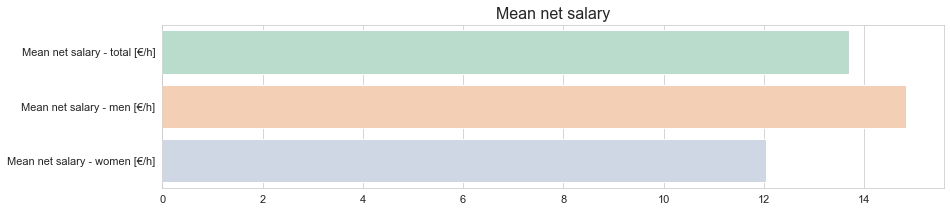

In [97]:
data_plot_1  = [data_1['mean net salary'].mean(), data_1['mean net salary for man'].mean(), data_1['mean net salary for women'].mean()]
labels = ['Mean net salary - total [€/h]', 'Mean net salary - men [€/h]', 'Mean net salary - women [€/h]']

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,3))

sns.barplot(x = data_plot_1, y=labels, palette='Pastel2')
ax.set_title("Mean net salary", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

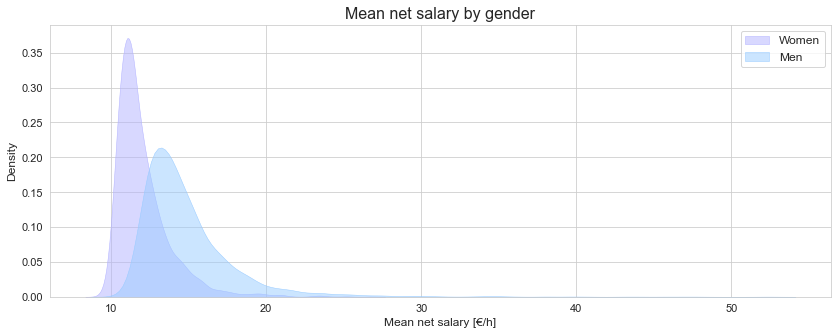

In [98]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

sns.kdeplot(data_1['mean net salary for women'], color="#b3b3ff", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary for man'], color="#99ccff", fill=True, alpha=.5, linewidth=0.5, label='Men')
ax.set_title("Mean net salary by gender", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

### 3.1.3. Mean salary by working position <a class="anchor" id="section_3_1_3"></a>

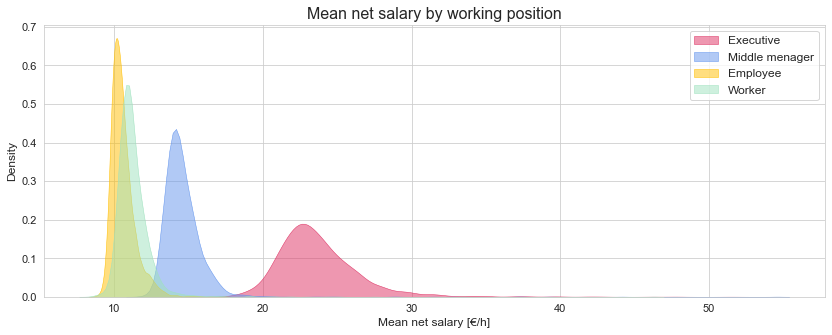

In [99]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for executive'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Executive')
sns.kdeplot(data_1['mean net salary per hour for middle manager'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Middle menager')
sns.kdeplot(data_1['mean net salary per hour for employee'], color="#FFBF00", fill=True, alpha=.5, linewidth=0.5, label='Employee')
sns.kdeplot(data_1['mean net salary per hour for worker'], color="#9FE2BF", fill=True, alpha=.5, linewidth=0.5, label='Worker')

ax.set_title("Mean net salary by working position", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

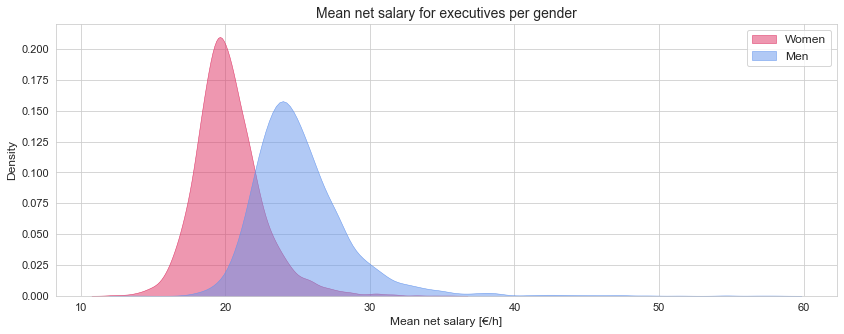

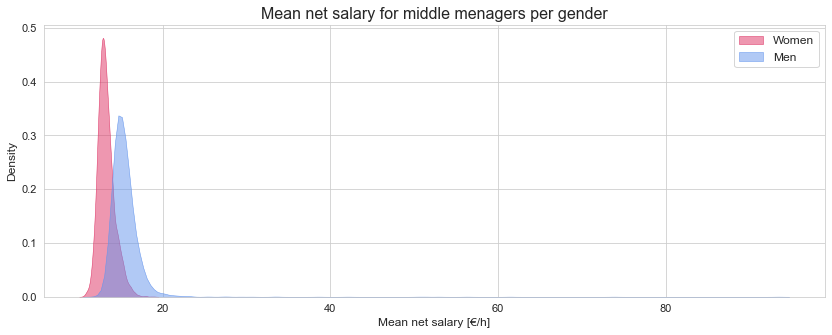

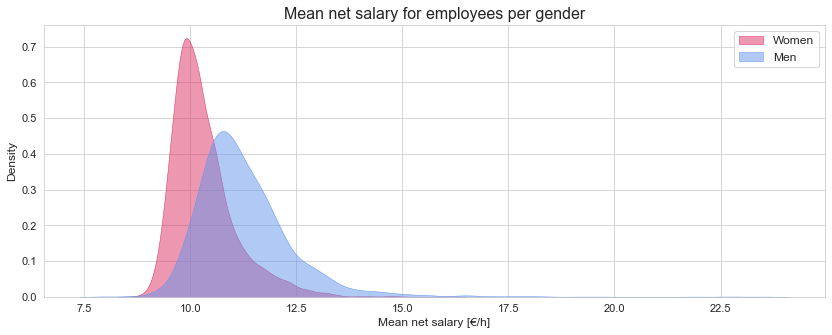

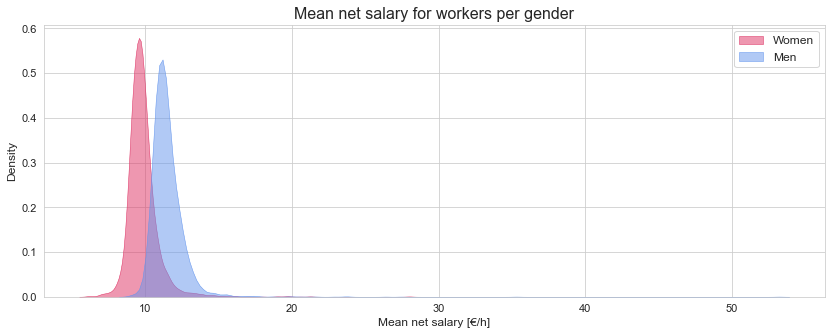

In [100]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for feminin executive'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary per hour for masculin executive'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Men')

ax.set_title("Mean net salary for executives per gender", fontsize=14)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for feminin middle manager'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary per hour for masculin middle manager'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Men')

ax.set_title("Mean net salary for middle menagers per gender", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for feminin employee'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary per hour for masculin employee'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Men')

ax.set_title("Mean net salary for employees per gender", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()


sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for feminin worker'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary per hour for masculin worker'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Men')

ax.set_title("Mean net salary for workers per gender", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

### 3.1.4. Mean salary by age <a class="anchor" id="section_3_1_4"></a>

Net payment is starting to grow with the age. The discrepancies between gender payments are getting more visible with the age.

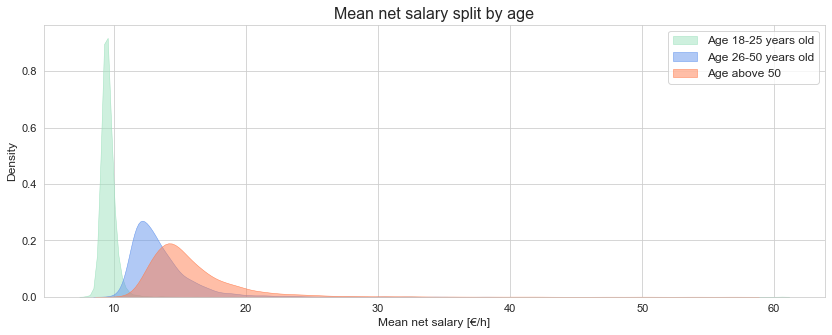

In [101]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))
    
sns.kdeplot(data_1['mean net salary per hour for 18-25 years old'], color="#9FE2BF", fill=True, alpha=.5, linewidth=0.5, label='Age 18-25 years old')
sns.kdeplot(data_1['mean net salary per hour for 26-50 years old'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Age 26-50 years old')
sns.kdeplot(data_1['mean net salary per hour for >50 years old'], color="#FF7F50", fill=True, alpha=.5, linewidth=0.5, label='Age above 50')

ax.set_title("Mean net salary split by age", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

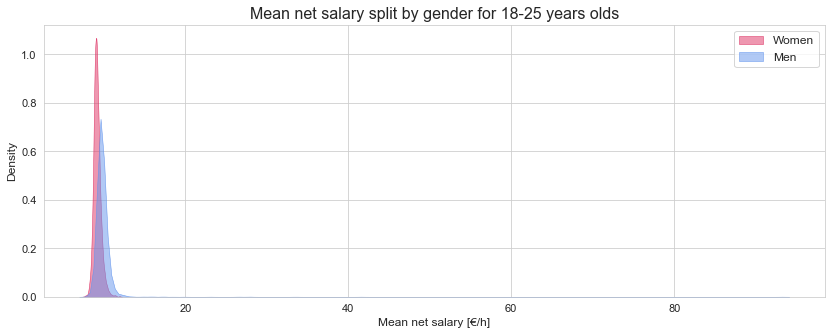

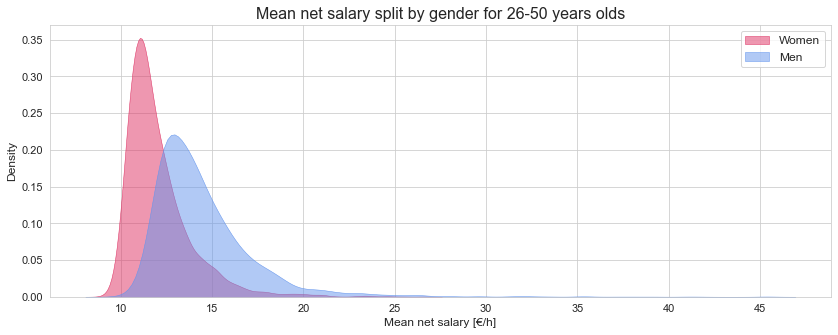

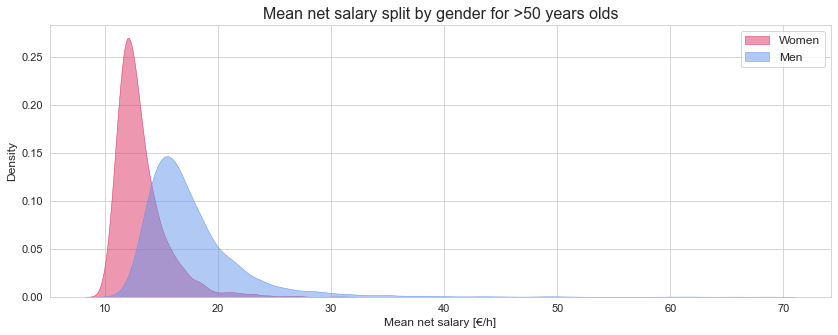

In [102]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for women between 18-25 years old'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary per hour for men between 18-25 years old'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Men')

ax.set_title("Mean net salary split by gender for 18-25 years olds", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for women between 26-50 years old'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary per hour for men between 26-50 years old'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Men')

ax.set_title("Mean net salary split by gender for 26-50 years olds", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,5))

    
sns.kdeplot(data_1['mean net salary per hour for women >50 years old'], color="#DE3163", fill=True, alpha=.5, linewidth=0.5, label='Women')
sns.kdeplot(data_1['mean net salary per hour for men >50 years old'], color="#6495ED", fill=True, alpha=.5, linewidth=0.5, label='Men')

ax.set_title("Mean net salary split by gender for >50 years olds", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

## 3.2. Labour situation by regions <a class="anchor" id="section_3_2"></a>

### 3.2.1. Mean salary per region <a class="anchor" id="section_3_2_1"></a>
Some of France Regions have been merged during last period. Data have been updated to reflect those changes and new Region names.

In [103]:
data_regions = data_2[['code_insee', 'EU_circo', 'code_région', 'nom_région', 'chef.lieu_région']]

In [104]:
data_regions = data_regions.drop_duplicates()

In [105]:
data_regions['code_insee'] = data_regions['code_insee'].apply(lambda x: '{0:0>5}'.format(x))

In [106]:
data_1['unique code of the town'] = data_1['unique code of the town'].apply(lambda x: '{0:0>5}'.format(x))

In [107]:
data_3 = data_1.merge(data_regions, left_on='unique code of the town', right_on='code_insee')

In [108]:
region_update = {
    'Auvergne' : 'Auvergne-Rhône-Alpes',
    'Rhône-Alpes' : 'Auvergne-Rhône-Alpes',
    'Burgundy' : 'Bourgogne-Franche-Comté',
    'Bourgogne':'Bourgogne-Franche-Comté',
    'Franche-Comté' : 'Bourgogne-Franche-Comté',
    'Alsace' : 'Grand Est',
    'Champagne-Ardenne' : 'Grand Est',
    'Lorraine' : 'Grand Est',
    'Nord-Pas-de-Calais' : 'Hauts-de-France',
    'Picardie' : 'Hauts-de-France',
    'Picardy' : 'Hauts-de-France',
    'Lower Normandy' : 'Normandie',
    'Upper Normandy' : 'Normandie',
    'Basse-Normandie' : 'Normandie',
    'Haute-Normandie' : 'Normandie',
    'Aquitaine' : 'Nouvelle-Aquitaine',
    'Limousin' : 'Nouvelle-Aquitaine',
    'Poitou-Charentes' : 'Nouvelle-Aquitaine',
    'Languedoc-Roussillon' : 'Occitanie',
    'Midi-Pyrénées' : 'Occitanie',
    'Centre' : 'Centre-Val de Loire',
    'Corse' : 'Corse'
}

In [109]:
def update_regions(row):
    if row in region_update.keys():
        row = region_update[row]
    else:
        row = row
    return row

In [110]:
data_3['nom_région'] = data_3['nom_région'].apply(update_regions)

In [111]:
data_4 = data_3.groupby(by='nom_région').mean()

In [112]:
data_4.reset_index(inplace=True)

In [113]:
france_url = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions.geojson'

In [114]:
response = requests.get(france_url)

In [115]:
payload = response.json()

In [116]:
region_map = {}
for feature in payload['features']:
    feature['id'] = feature['properties']['code'] #creating id to map with real file   
    region_map[feature['properties']['nom']] = feature['properties']['code'] #creating same id inside the geojson

In [117]:
def update_codes(row):
    if row in region_map.keys():
        return region_map[row]
    else:
        return np.NaN

In [118]:
data_4['region_code'] = data_4['nom_région'].apply(update_codes)

In [119]:
fig = px.choropleth_mapbox(data_frame=data_4, geojson=payload, 
                    locations='region_code', #where is mapped id in data
                    color='mean net salary', #column will be used for coloring map  
#                    scope='europe', 
                    hover_name = 'nom_région', #names of parts will be taken from here
#                    hover_data = []) #columns data should be additionally showed
                    mapbox_style = 'carto-positron',      #mapbox layers from plotly.
                    center={'lat': 47, 'lon': 2.3}, #where map should have a center
                    zoom = 4,
                    opacity = 0.4, #visibility
                    title= "Mean net salary per regions [€/h]"
                   )
# fig.update_goes(fitbounds='locations', visible=False);
fig.show()

### 3.2.2. Regions with the lowest and highest salaries <a class="anchor" id="section_3_2_2"></a>

In [120]:
data_per_region_top_low = data_4.loc[:, ["nom_région", "mean net salary"]].sort_values(by="mean net salary", ascending=False)

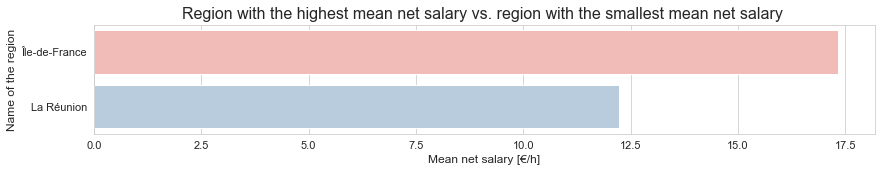

In [121]:
data_per_region_top_low_1 = pd.concat([data_per_region_top_low[0:1], data_per_region_top_low[-1:]])

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,2))

    
sns.barplot(data = data_per_region_top_low_1, x = data_per_region_top_low_1['mean net salary'], y = data_per_region_top_low_1['nom_région'], palette='Pastel1')

ax.set_title("Region with the highest mean net salary vs. region with the smallest mean net salary ", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the region", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()


### 3.2.3. Salary per region and gender <a class="anchor" id="section_3_2_3"></a>

In [122]:
data_4['salary_gap'] = data_4['mean net salary for man'] - data_4['mean net salary for women']

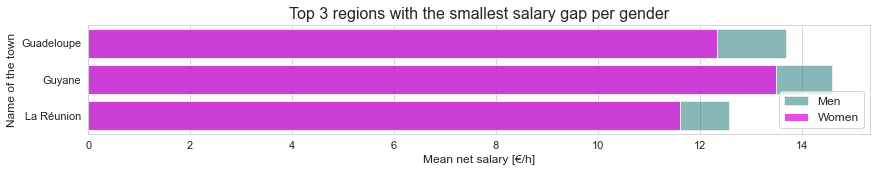

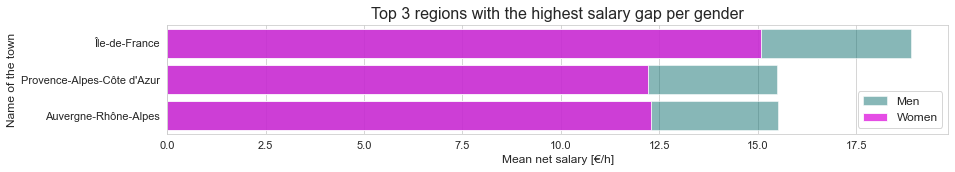

In [123]:
gap_region = data_4.sort_values(by='salary_gap', ascending=False)[-3:]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,2))

sns.barplot(data = gap_region, x = 'mean net salary for man', y = 'nom_région', alpha=0.5, color="#008080", label='Men')
sns.barplot(data = gap_region, x = 'mean net salary for women', y = 'nom_région', alpha=0.8, color="#FF00FF", label='Women')   

ax.set_title("Top 3 regions with the smallest salary gap per gender", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(fontsize=12)

plt.show()

gap_region = data_4.sort_values(by='salary_gap', ascending=False)[:3]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,2))

sns.barplot(data = gap_region, x = 'mean net salary for man', y = 'nom_région', alpha=0.5, color="#008080", label='Men')
sns.barplot(data = gap_region, x = 'mean net salary for women', y = 'nom_région', alpha=0.8, color="#FF00FF", label='Women')   

ax.set_title("Top 3 regions with the highest salary gap per gender", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(fontsize=12)

plt.show()

## 3.3. Labour situation by cities <a class="anchor" id="section_3_3"></a>

### 3.3.1. Mean salary per town <a class="anchor" id="section_3_3_1"></a>

In [124]:
data_per_town = data_1.loc[:, ["name of the town", "mean net salary"]].sort_values(by="mean net salary", ascending=False)

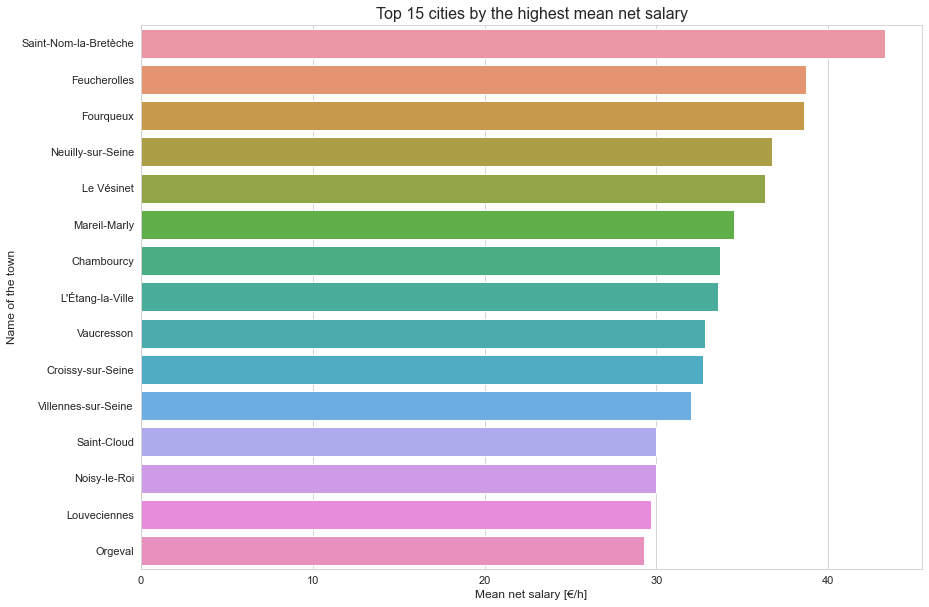

In [125]:
data_per_town_top_15 = data_per_town[0:15]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,10))

    
sns.barplot(data = data_per_town_top_15, x = data_per_town_top_15['mean net salary'], y = data_per_town_top_15['name of the town'])

ax.set_title("Top 15 cities by the highest mean net salary", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()


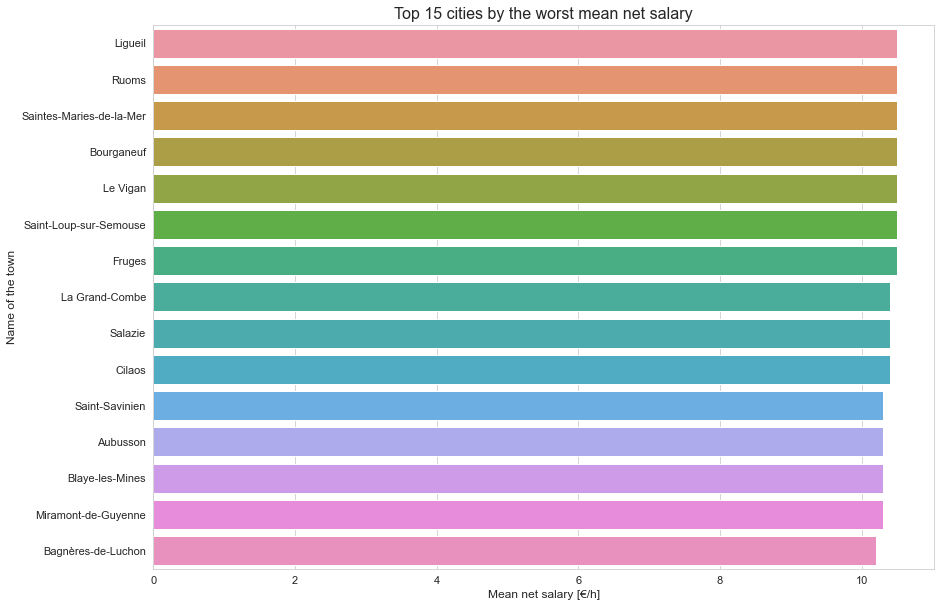

In [126]:
data_per_town_worst_15 = data_per_town[-15:]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,10))

    
sns.barplot(data = data_per_town_worst_15, x = data_per_town_worst_15['mean net salary'], y = data_per_town_worst_15['name of the town'])

ax.set_title("Top 15 cities by the worst mean net salary", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

### 3.3.2. Mean salary per town and gender <a class="anchor" id="section_3_3_2"></a>

In [127]:
salary_per_town_2 = data_1.loc[:, ["name of the town", "mean net salary", "mean net salary for women", "mean net salary for man"]]

In [128]:
salary_per_town_2['gender payment difference (men - woman)'] = salary_per_town_2['mean net salary for man'] - salary_per_town_2['mean net salary for women']

In [129]:
salary_per_town_2.sort_values(by='gender payment difference (men - woman)', ascending=False, inplace=True)

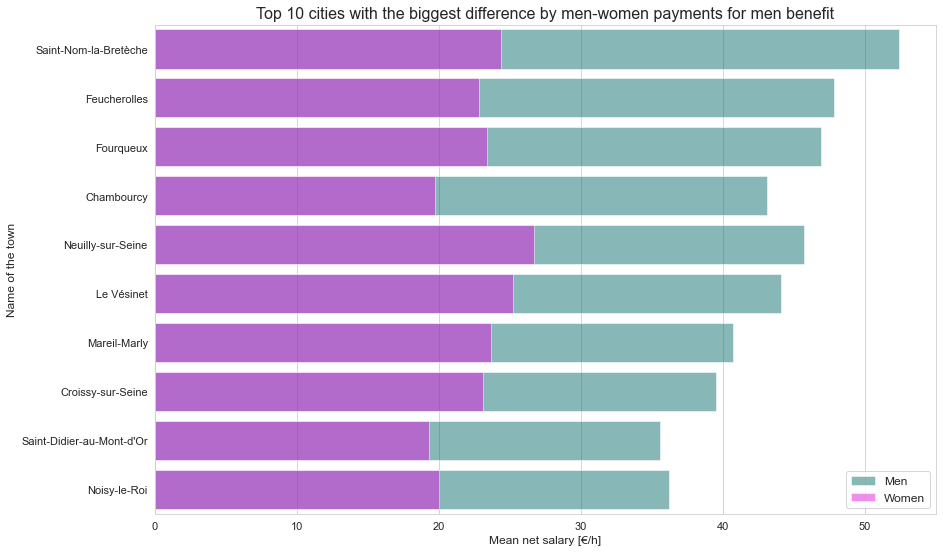

In [130]:
salary_per_town_2_M = salary_per_town_2[:10]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,9))

    
sns.barplot(data = salary_per_town_2_M, x = 'mean net salary for man', y = 'name of the town', alpha=0.5, color="#008080", label='Men')
sns.barplot(data = salary_per_town_2_M, x = 'mean net salary for women', y = 'name of the town', alpha=0.5, color="#FF00FF", label='Women')

ax.set_title("Top 10 cities with the biggest difference by men-women payments for men benefit", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(fontsize=12)

plt.show()

In the whole country there are only two towns where is noted higher average payment for women than men. However, the difference is slight.

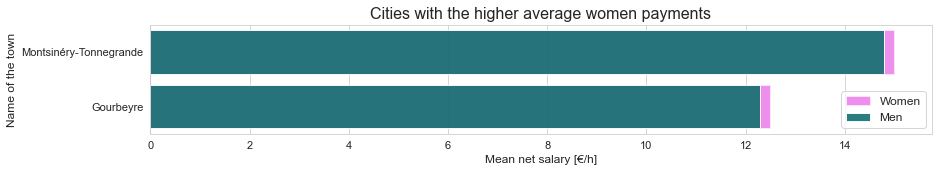

In [131]:
salary_per_town_2_K = salary_per_town_2[salary_per_town_2['mean net salary for women'] > salary_per_town_2['mean net salary for man']]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,2))

sns.barplot(data = salary_per_town_2_K, x = 'mean net salary for women', y = 'name of the town', alpha=0.5, color="#FF00FF", label='Women')   
sns.barplot(data = salary_per_town_2_K, x = 'mean net salary for man', y = 'name of the town', alpha=0.9, color="#008080", label='Men')

ax.set_title("Cities with the higher average women payments", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(fontsize=12)

plt.show()

In [132]:
salary_per_town_2_0 = salary_per_town_2[salary_per_town_2['gender payment difference (men - woman)'] < 0.5]

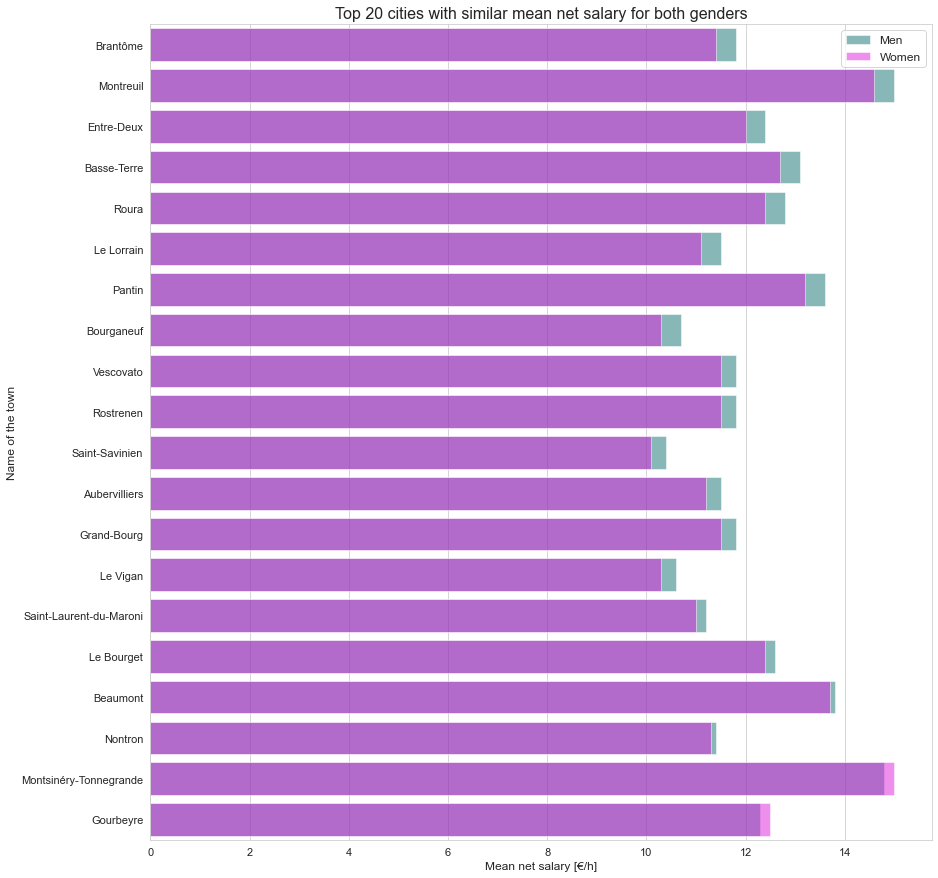

In [133]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,15))

sns.barplot(data = salary_per_town_2_0, x = 'mean net salary for man', y = 'name of the town', alpha=0.5, color="#008080", label='Men')
sns.barplot(data = salary_per_town_2_0, x = 'mean net salary for women', y = 'name of the town', alpha=0.5, color="#FF00FF", label='Women')   

ax.set_title("Top 20 cities with similar mean net salary for both genders", fontsize=16)
ax.set_xlabel("Mean net salary [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(fontsize=12)

plt.show()

### 3.3.3. Mean salary per town and age <a class="anchor" id="section_3_3_3"></a>

In [134]:
salary_per_town_3 = data_1.loc[:, ["name of the town", "mean net salary per hour for 18-25 years old", "mean net salary per hour for 26-50 years old", "mean net salary per hour for >50 years old"]]

In [135]:
salary_per_town_3['Mean salary difference by Age'] = salary_per_town_3["mean net salary per hour for >50 years old"] - salary_per_town_3["mean net salary per hour for 18-25 years old"]

In [136]:
salary_per_town_3.sort_values(by='Mean salary difference by Age', ascending=False, inplace=True)

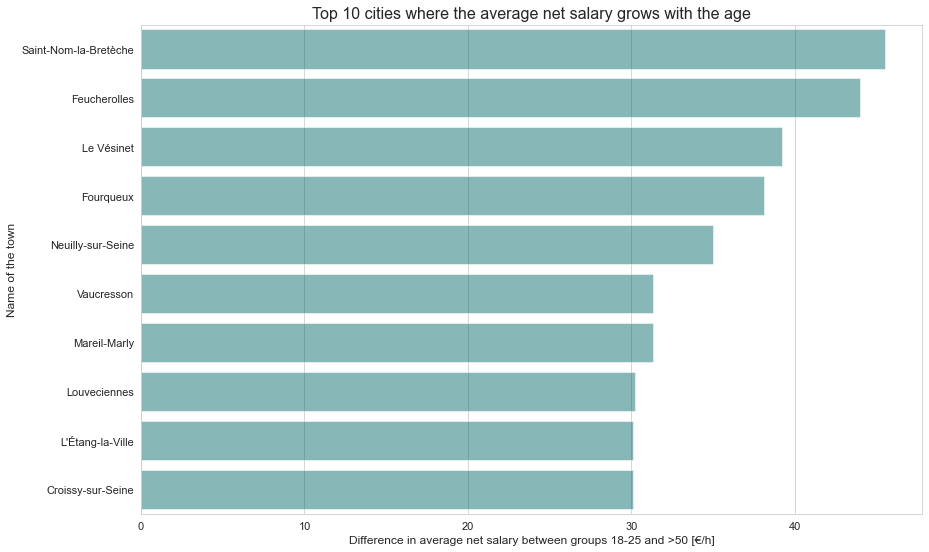

In [137]:
salary_per_town_3_H = salary_per_town_3[:10]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,9))

sns.barplot(data = salary_per_town_3_H, x = 'Mean salary difference by Age', y = 'name of the town', alpha=0.5, color="#008080")

ax.set_title("Top 10 cities where the average net salary grows with the age", fontsize=16)
ax.set_xlabel("Difference in average net salary between groups 18-25 and >50 [€/h]", fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

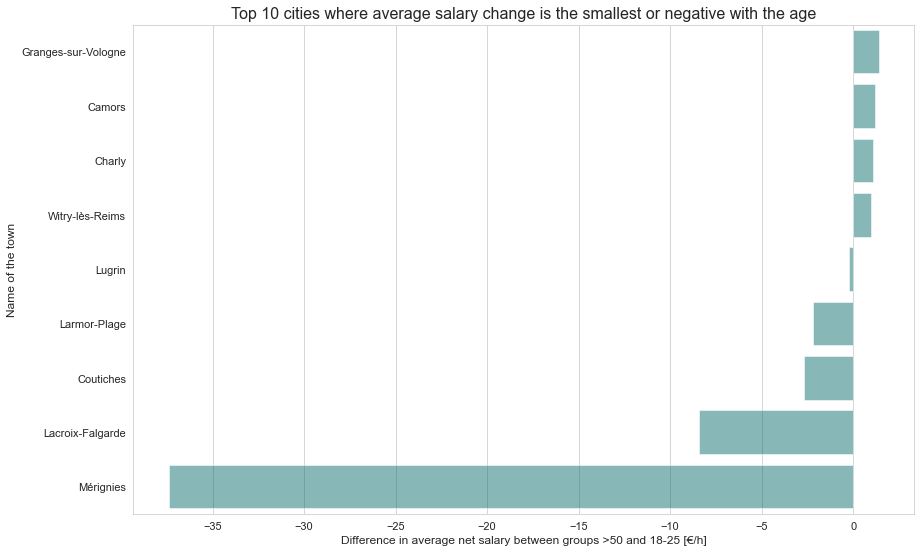

In [138]:
salary_per_town_3_H = salary_per_town_3[-9:]

sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(14,9))

sns.barplot(data = salary_per_town_3_H, x = 'Mean salary difference by Age', y = 'name of the town', alpha=0.5, color="#008080")

ax.set_title("Top 10 cities where average salary change is the smallest or negative with the age", fontsize=16)
ax.set_xlabel("Difference in average net salary between groups >50 and 18-25 [€/h]" , fontsize=12)
ax.set_ylabel("Name of the town", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()

In [139]:
!jupyter nbconvert "Report_net_salary_france.ipynb" --TagRemovePreprocessor.remove_cell_tags="{'hide'}" --TagRemovePreprocessor.remove_input_tags="{'hide_input'}" --to html --no-input

[NbConvertApp] Converting notebook Report_net_salary_france.ipynb to html
[NbConvertApp] Writing 2955459 bytes to Report_net_salary_france.html
